# Application to breast cancer dataset

## Prepare dataset

### Load

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 10

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
data_X, y = data.data, data.target

X = pd.DataFrame(data=data_X, columns=data.feature_names)

### Create artificial categorical variable
For illustration purposes, create a random categorical feature

In [2]:
X["category"] = np.where(X["mean smoothness"] <= 0.1, "A", "B")

### Split train/test

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

### Create unknown category in test set
To illustrate robustness of implementation, create unknown category in test set

In [4]:
X_test["category"] = "C"

## Automatically create binary features 



### Call AutoBinarizer

The binary feature creation is based on train dataset.      
The train and test dataset are then transformed for training and evaluation.

In [5]:
from scorepyo.preprocessing import AutoBinarizer


binarizer = AutoBinarizer(max_number_binaries_by_features=3, keep_negative=True)
binarizer.fit(X_train, y_train, categorical_features="auto", to_exclude_features=None)

X_train_binarized, df_info = binarizer.transform(X_train)
X_test_binarized, _ = binarizer.transform(X_test)

In [6]:
X_train_binarized.sample(3)

,mean radius < 12.26,12.26 <= mean radius < 14.66,mean radius >= 14.66,mean texture < 17.2,17.2 <= mean texture < 20.66,...,worst fractal dimension < 0.07,0.07 <= worst fractal dimension < 0.09,worst fractal dimension >= 0.09,category_A,category_B
9,1,0,0,0,1,...,0,0,1,0,1
368,0,1,0,1,0,...,0,1,0,1,0
28,1,0,0,1,0,...,0,0,1,0,1


### Display information from binarizer

The binarizer also outputs a dataframe containing information about the binarizer. 
This information can be later used to for the display of the `OptunaRiskScore` model.

It contains the following information for each binary feature created:
* name of binary feature
* log-odd coefficient of the binary feature according to EBM underlying model
* lower and upper threshold value used for creating the interval on the original feature domain
* name of the original feature

In [7]:
df_info

,EBM_log_odds_contribution,lower_threshold,upper_threshold,feature
binary_feature,,,,
mean radius < 12.26,0.135708,NaN,12.26,mean radius
12.26 <= mean radius < 14.66,0.086529,12.26,14.66,mean radius
mean radius >= 14.66,-0.222237,14.66,NaN,mean radius
mean texture < 17.2,0.740917,NaN,17.205,mean texture
17.2 <= mean texture < 20.66,0.056726,17.205,20.665,mean texture
...,...,...,...,...
0.07 <= worst fractal dimension < 0.09,0.372596,0.07428,0.08649,worst fractal dimension
worst fractal dimension >= 0.09,-0.156302,0.08649,NaN,worst fractal dimension
category_A,None,None,None,category


## Train RiskScore model

The RiskScore models can take 4 parameters:
* `nb_max_features` : number of maximum binary features to use for the risk score model
* `min_point_value` : minimum possible number of points for each binary feature
* `max_point_value` : maximum possible number of points for each binary feature
* `df_info`         : optional dataframe containing the correspondance between original feature and the binary feature. It must contain 2 columns *feature* and *binary_feature*.

Since the `OptunaRiskScore` model is based on Optuna, we can also pass specific Optuna optimize function parameters via a dictionnary in the  `optuna_optimize_params` parameter.

In [8]:
from scorepyo.models import OptunaRiskScore


scorepyo_model = OptunaRiskScore(
    nb_max_features=4,
    min_point_value=-1,
    max_point_value=2,
    df_info=df_info["feature"].reset_index(),
)

scorepyo_model.fit(X_train_binarized, y_train)

### Display the summary of the risk score model

The summary of the risk score built by the model.  

It displays two elements :
* Feature-point card : Points for each selected binary feature
* Score card : Scores (=sum of points) with their associated probability

In [9]:
scorepyo_model.summary()

| FEATURE-POINT CARD |
| Feature              | Description                  | Point(s)   |       |
|:---------------------|:-----------------------------|:-----------|:------|
| mean symmetry        | 0.17 <= mean symmetry < 0.19 | -1         | ...   |
| mean perimeter       | mean perimeter >= 95.84      | -1         | + ... |
| worst concave points | worst concave points >= 0.14 | -1         | + ... |
| mean concavity       | mean concavity < 0.04        | 2          | + ... |
|                      |                              | SCORE=     | ...   |


|     SCORE CARD     |
| SCORE   | -3     | -2     | -1     | 0      | 1      | 2      |
|:--------|:-------|:-------|:-------|:-------|:-------|:-------|
| RISK    | 26.89% | 50.00% | 73.11% | 88.08% | 95.26% | 98.20% |


## Evaluation on test set

### Precision-Recall curve on test set

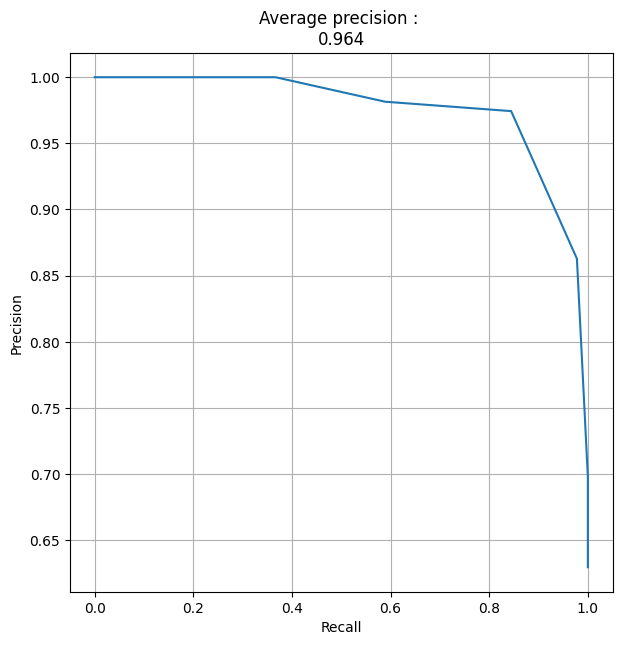

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


y_proba = scorepyo_model.predict_proba(X_test_binarized)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()